**In this projects, the goal was to target and detect 8 Objects (retinal lesions), that were manually annotated in the training and the validating datasets to be auto-recoginsed using Mask R neural network.**


1. Drusen
2. intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation
3. The choroidal neovascular membrane (CNV)
4. fibrovascular pigment epithelial detachments (PEDs)
5. Central serous chorioretinopathy (CSR)
6. Exudate
7. central retinal vein occlusion (CRVO)
8. Sub-retinal fluid

**Datasets:**
3 datasets are used (training, validating, and testing)
The training and validating images are manually annotated to detect the desired objects.

48 images are used to train the model, while 12 images are used for validation.

the accuracy of the model is determined based on 102 images in the test set.   


In [ ]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive 

In [ ]:
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/maskrcnn/')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [ ]:
ROOT_DIR = '/content/drive/My Drive/maskrcnn'

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

class CustomConfig(Config):

    
    NAME = "object"


    IMAGES_PER_GPU = 1

    
    NUM_CLASSES = 1 + 8 

    
    STEPS_PER_EPOCH = 10

    # Skip detections with < 50% confidence
    DETECTION_MIN_CONFIDENCE = 0.50

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.add_class("object", 1, 'Drusen')
        self.add_class("object", 2, 'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation')
        self.add_class("object", 3, 'The choroidal neovascular membrane (CNV)')
        self.add_class("object", 4, ' fibrovascular pigment epithelial detachments (PEDs)')
        self.add_class("object", 5, 'Central serous chorioretinopathy (CSR)')
        self.add_class("object", 6, 'Exudate')
        self.add_class("object", 7, 'central retinal vein occlusion (CRVO)')
        self.add_class("object", 8, 'Sub-retinal fluid')


        dataset_dir = os.path.join(dataset_dir, subset)


        
        annotations1 = json.load(open(os.path.join(dataset_dir, f'{subset}.json')))
        annotations = list(annotations1.values())  

 
        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            polygons = [a['regions'][r]['shape_attributes'] for r in a['regions']] 
            objects = [a['regions'][s]['region_attributes']['label'] for s in a['regions']]
            print("objects:",objects)
        
            name_dict = {'Drusen': 1,
                         'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation': 2,
                         'The choroidal neovascular membrane (CNV)': 3,
                         ' fibrovascular pigment epithelial detachments (PEDs)': 4,
                         'Central serous chorioretinopathy (CSR)': 5,
                         'Exudate': 6,
                         'central retinal vein occlusion (CRVO)': 7,
                         'Sub-retinal fluid': 8 
                        } 
            
            num_ids = [name_dict[a] for a in objects]
     
            
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)


        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
          rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
          mask[rr, cc, i] = 1


        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
def train(model):
    """Train the model."""

    dataset_train = CustomDataset()
    dataset_train.load_custom('/content/drive/My Drive/maskrcnn/dataset','train')
    dataset_train.prepare()

    dataset_val = CustomDataset()
    dataset_val.load_custom('/content/drive/My Drive/maskrcnn/dataset', 'val')
    dataset_val.prepare()
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
train(model)			

objects: ['Drusen']
numids [1]
objects: ['intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation', 'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation']
numids [2, 2]
objects: ['Drusen', 'Drusen', 'Drusen', 'Drusen', 'Drusen']
numids [1, 1, 1, 1, 1]
objects: ['Drusen', 'Drusen', 'Drusen']
numids [1, 1, 1]
objects: ['Drusen', 'Drusen']
numids [1, 1]
objects: ['The choroidal neovascular membrane (CNV)']
numids [3]
objects: ['Drusen']
numids [1]
objects: ['Drusen']
numids [1]
objects: ['The choroidal neovascular membrane (CNV)', 'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation']
numids [3, 2]
objects: ['The choroidal neovascular membrane (CNV)', 'The choroidal neovascular membrane (CNV)', 'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation']
numids [3, 3, 2]
objects: [' fibrovascular pigment epithelial detachments (PEDs)']
numids [4]
objects: ['Drusen']
numids [1]
objects: [' fibrovascular pigment epithelial detachments (PEDs)', ' fib

In [ ]:
# Inspecting the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/drive/My Drive/maskrcnn/"

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

CUSTOM_DIR = "/content/drive/My Drive/maskrcnn/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()

dataset_test = CustomDataset()
dataset_test.load_custom(CUSTOM_DIR, "val")
dataset_test.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Central serous chorioretinopathy (CSR)']
numids [5]
objects: ['Drusen']
numids [1]
objects: [' fibrovascular pigment epithelial detachments (PEDs)']
numids [4]
objects: [' fibrovascular pigment epithelial detachments (PEDs)', 'Drusen']
numids [4, 1]
objects: [' fibrovascular pigment epithelial detachments (PEDs)']
numids [4]
objects: [' fibrovascular pigment epithelial detachments (PEDs)']
numids [4]
objects: [' fibrovascular pigment epithelial detachments (PEDs)', ' fibrovascular pigment epithelial detachments (PEDs)', 'Exudate', 'Exudate']
numids [4, 4, 6, 6]
objects: ['Exudate', 'intraretinal fluid (IRF) and subretinal fluid (SRF) accumulation', ' fibrovascular pigment epithelial detachments (PEDs)', ' fibrovascular pigment epithelial detachments (PEDs)']
numids [6, 2, 4, 4]
objects: [' fibrovascular pigment epithelial detachments (PEDs)', ' fibrovascular pigment epithelial detachments (PEDs)']
numids [4, 4]
objects: ['Central serous chorioretinopathy (CSR)', 'intraretina

In [ ]:
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

model_path = model.find_last()

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/maskrcnn/logs/object20210328T0150/mask_rcnn_object_0010.h5
Re-starting from epoch 10


In [ ]:
# Testing the model

image_id = random.choice(dataset.image_ids)
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

results = model.detect([image], verbose=1)

image id is : 0
image ID: object.AMRD37.jpeg (0) /content/drive/My Drive/maskrcnn/dataset/val/AMRD37.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


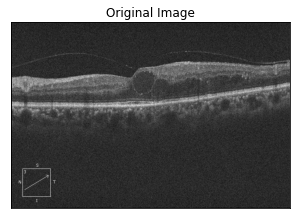

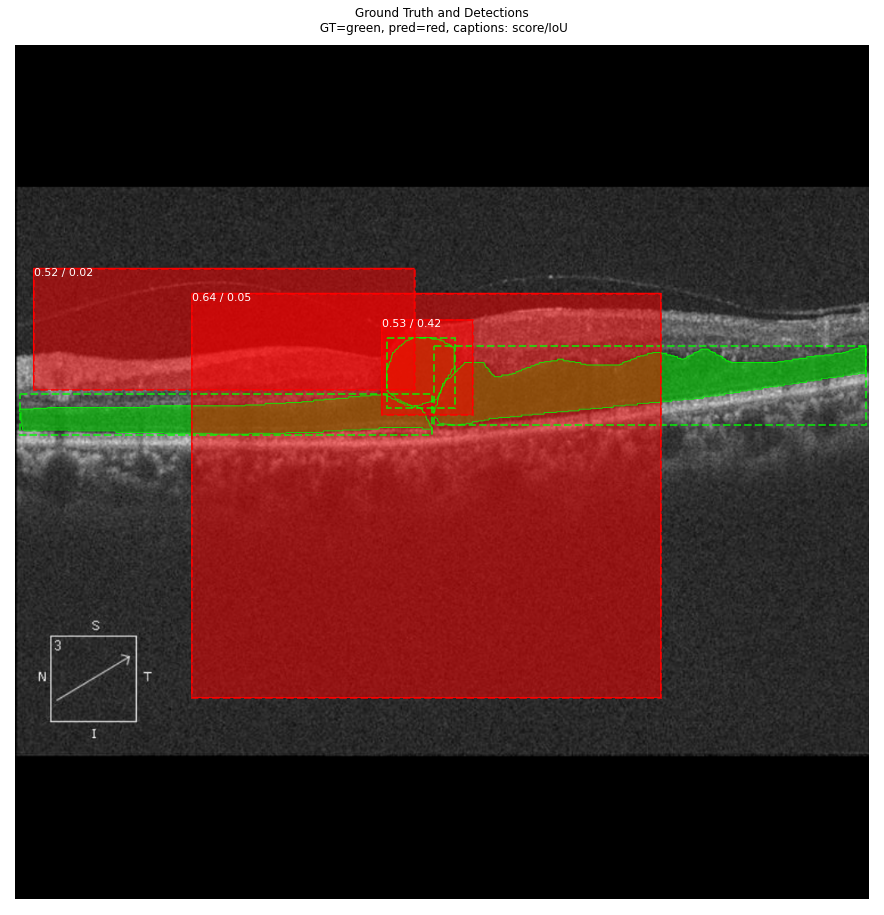

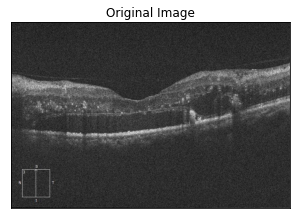

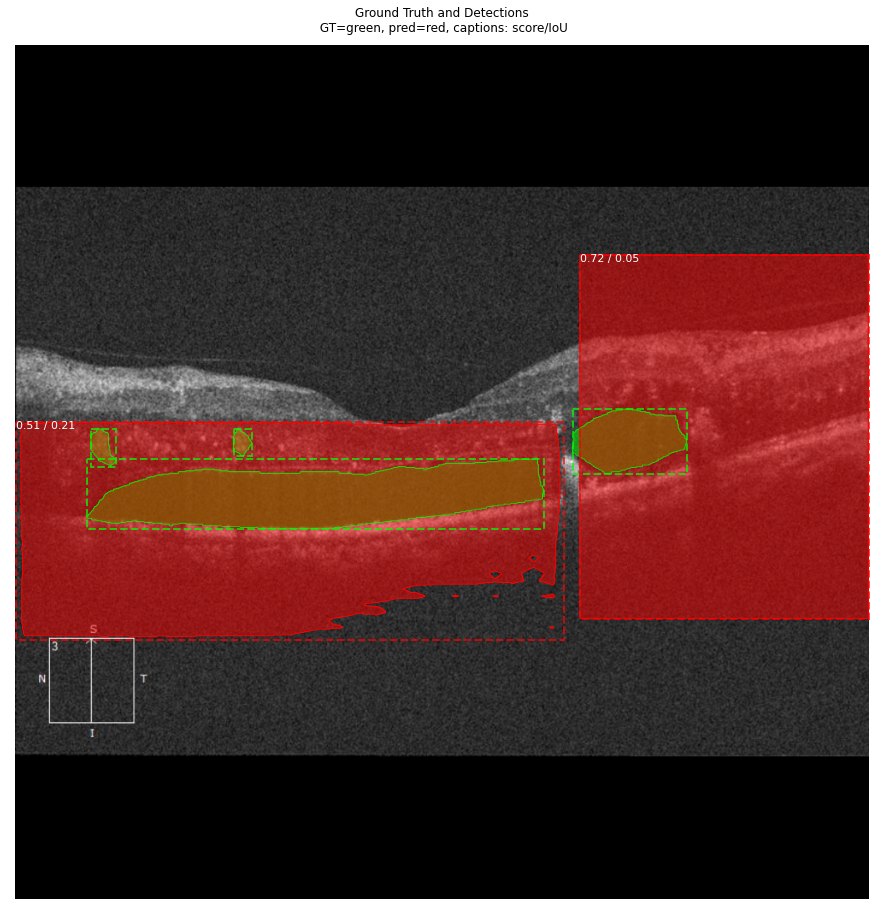

In [ ]:
# Comparing ground truth and predictions
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)
    
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

ind = 9
display_image(dataset, ind)
predict_and_plot_differences(dataset, ind)

ind = 6
display_image(dataset, ind)
predict_and_plot_differences(dataset, ind)

1
Processing 1 images
image                    shape: (500, 750, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


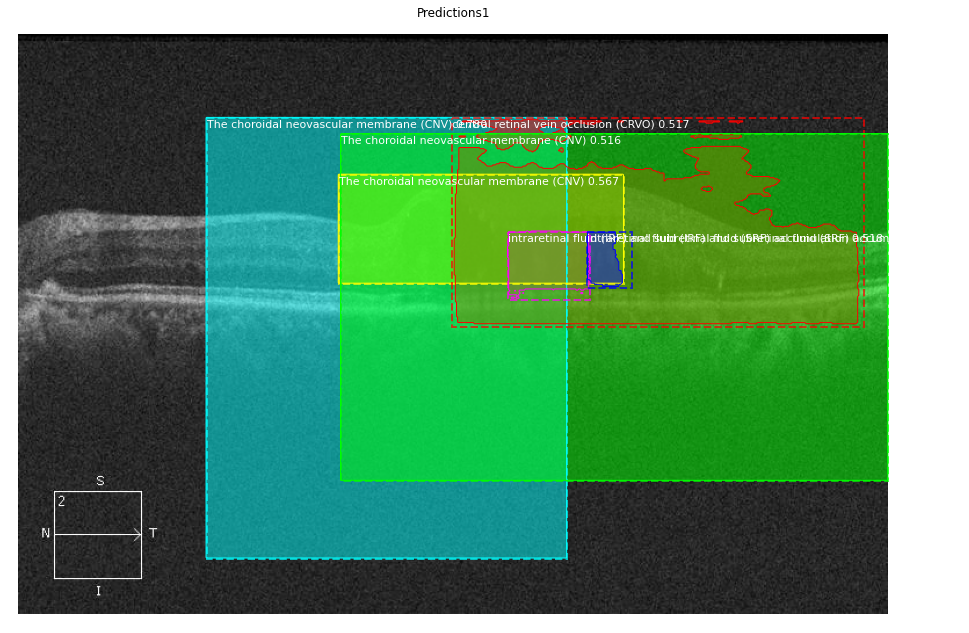

In [ ]:
path_to_new_image = '/content/drive/My Drive/maskrcnn/dataset/test/DR12.jpeg' 
image1 = mpimg.imread(path_to_new_image)

print(len([image1]))
results1 = model.detect([image1], verbose=1)

ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

1
Processing 1 images
image                    shape: (586, 879, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


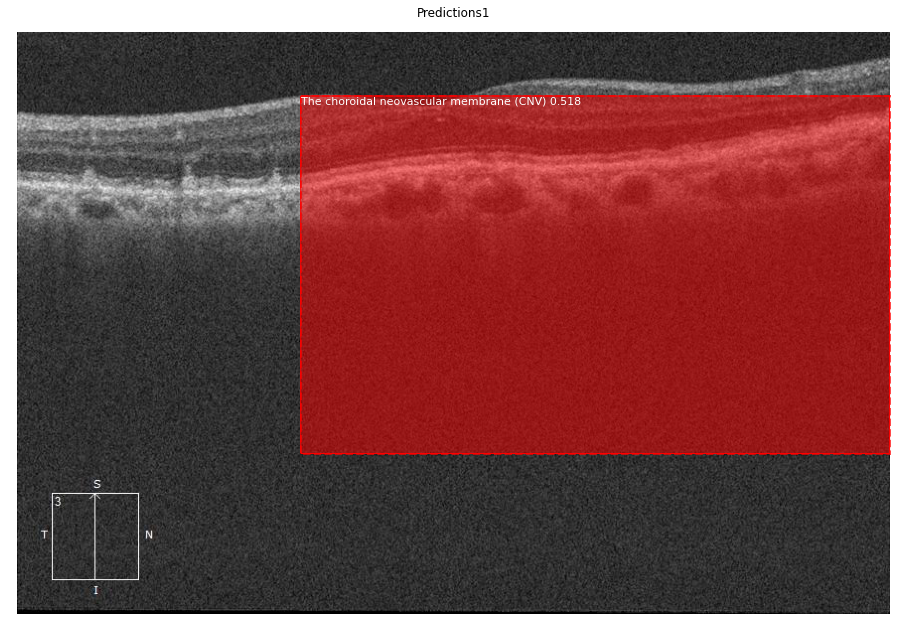

In [ ]:
path_to_new_image = '/content/drive/My Drive/maskrcnn/dataset/test/AMRD11.jpeg'
image1 = mpimg.imread(path_to_new_image)

print(len([image1]))
results1 = model.detect([image1], verbose=1)

ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")